<a href="https://colab.research.google.com/github/respect5716/deep-learning-paper-implementation/blob/main/01_General/Fourier%20Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Features

## 0. Info

### Paper
* title: Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains
* author: Matthew Tancik et al.
* url: https://arxiv.org/abs/2006.10739

### Features
* None

### Reference
* https://github.com/ndahlquist/pytorch-fourier-feature-networks

## 1. Setup

In [ ]:
import os
import easydict
import requests
from glob import glob
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

In [ ]:
cfg = easydict.EasyDict(
    device = 'cuda',
    img_size = 256,
)

## 2. Data

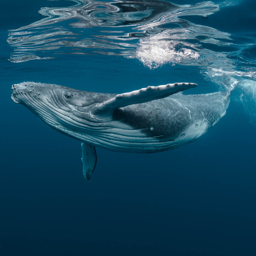

In [ ]:
img_url = 'https://nationaltoday.com/wp-content/uploads/2021/10/world-whale-day.jpg'
img = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
img.resize((cfg.img_size, cfg.img_size))

In [ ]:
transform = T.Compose([
    T.Resize((cfg.img_size, cfg.img_size)),
    T.ToTensor(),
])

target = transform(img)
target = target.unsqueeze(0).to(cfg.device)

In [ ]:
coords = np.linspace(0, 1, target.shape[2], endpoint=False)
xy_grid = np.stack(np.meshgrid(coords, coords), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(cfg.device)

In [ ]:
xy_grid.shape, target.shape

(torch.Size([1, 2, 256, 256]), torch.Size([1, 3, 256, 256]))

## 3. Model

In [ ]:
class GaussianFourierFeatureTransform(nn.Module):
    def __init__(self, in_dim=2, out_dim=128, scale=10):
        super().__init__()
        self.B = torch.randn(in_dim, out_dim) * scale

    def forward(self, x):
        bs, ch, w, h = x.size()
        x = x.permute(0, 2, 3, 1).reshape(bs * w * h, ch)
        x = x @ self.B.to(x.device)
        x = x.view(bs, w, h, -1).permute(0, 3, 1, 2)
        x = 2 * np.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=1)

In [ ]:
gff = GaussianFourierFeatureTransform()

In [ ]:
model = nn.Sequential(
    nn.Conv2d(256, 256, kernel_size=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 256, kernel_size=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 256, kernel_size=1, padding=0),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 3, kernel_size=1, padding=0),
    nn.Sigmoid(),
).to(cfg.device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

## 4. Train

In [ ]:
x = gff(xy_grid)

  0%|          | 0/5000 [00:00<?, ?it/s]

0500


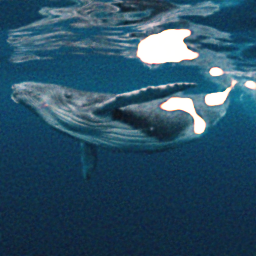

1000


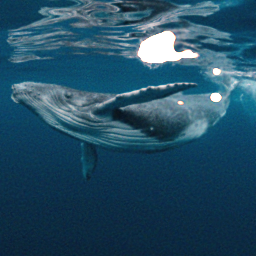

1500


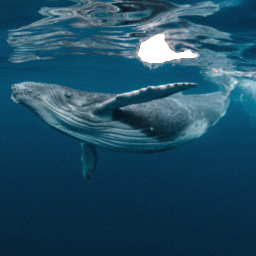

2000


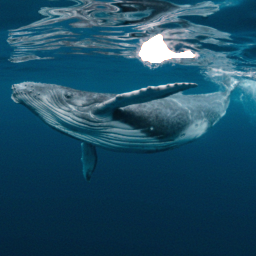

2500


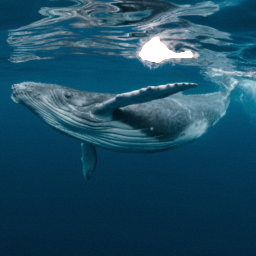

3000


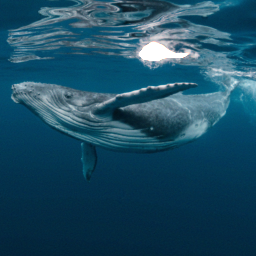

3500


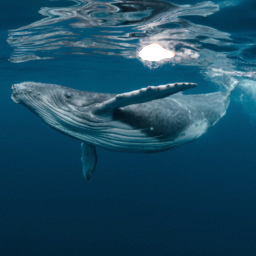

4000


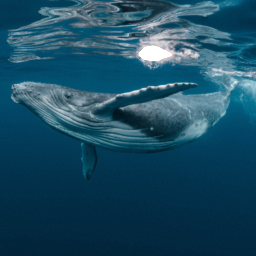

4500


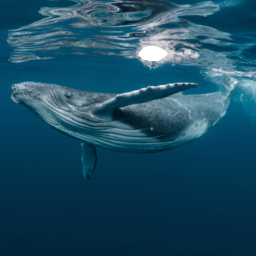

5000


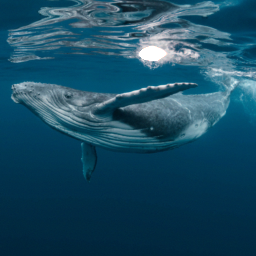

In [ ]:
pbar = tqdm(range(1, 5000+1))
for st in pbar:
    pred = model(x)
    loss = F.mse_loss(pred, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_postfix({'loss': loss.item()})
    if st % 500 == 0:
        print(f'{st:04d}')
        pred_img = T.ToPILImage()(pred[0])
        display(pred_img)